# Shape Detector 
Input: Points (floats) in a 2d grid which represent the boundary of a shape -- we will have an array of points, and these will be assumed to be sequentially the points that form the boundary of the closed shape

Output: The best ellipse, rectangle, triangle and 4-pointed star that fit to these points, along with the error of each (variance of pts from shape boundary, perhaps)

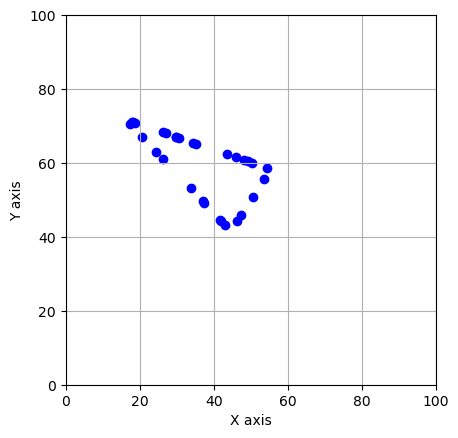

In [514]:
# Create example point list using a region
import numpy as np
import matplotlib.pyplot as plt
import math

# Generate randomly spaced points
def random_pts(num_pt, sl, bf):
    return np.random.uniform(bf, sl - bf, size = (num_pt, 2))

# Generate random points on a given circle
def circ_pts(num_pt, r, center, offset = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        theta = np.random.uniform(0, 2 * np.pi) # random angle
        r_cur = r + np.random.uniform(-offset, offset) # radius offset
        pts[i, :] = center[0] + r_cur * np.cos(theta), center[1] + r_cur * np.sin(theta)
    return pts

# Generate random points on a given ellipse
def ell_pts(num_pt, a, b, center, offset = 0, angle = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        theta = np.random.uniform(0, 2 * np.pi) # random angle
        a_cur = a + np.random.uniform(-offset, offset)
        b_cur = b + np.random.uniform(-offset, offset)
        pts[i, :] = center[0] + a_cur * np.cos(theta), center[1] + b_cur * np.sin(theta)
    return rotate_pts(pts, center, angle)

# Generate random points on given rectangle
def rect_pts(num_pt, a, b, center, offset = 0, angle = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        off_cur = np.random.uniform(-offset, offset)
        if np.random.uniform(0, 1) < a / (a + b):
            pts[i, :] = center[0] + np.random.uniform(-a / 2, a / 2),  center[1] + off_cur + np.random.choice([-1, 1]) * (b / 2)
        else:
            pts[i, :] = center[0] + off_cur + np.random.choice([-1, 1]) * (a / 2), center[1] + np.random.uniform(-b / 2, b / 2)
    return rotate_pts(pts, center, angle)

# Generate random points on a given triangle
def tri_pts(num_pt, a, b, base, offset = 0, angle = 0):
    pts = np.zeros((num_pt, 2))
    hyp = np.sqrt((a / 2) ** 2 + b ** 2) # length of tilted side
    for i in range(num_pt):
        off_cur = np.random.uniform(-offset, offset)
        x = np.random.uniform(-a/2, a/2)
        if np.random.uniform(0, 1) > 2 * hyp / (2 * hyp + a):
            pts[i, :] = base[0] + x, base[1] + off_cur
        else:
            pts[i, :] = base[0] + x + off_cur * b ** 2 / hyp ** 2, base[1] + b * (1 - 2 * abs(x) / a) + off_cur * a ** 2 / (4 * hyp ** 2)
    return rotate_pts(pts, base, angle)

# Generate random points on a given 4-pt star
def star_pts(num_pt, r, center, offset = 0, angle = 0):
    def rc(a = -1, b = 1): # random choice function
        return np.random.choice([a, b])
    sc = 0.25 # scale parameter, can be changed
    crit = sc * r
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        # Random parameter pair
        x = np.random.uniform(0, crit)
        y = r + x * (1 - 1 / sc)
        if rc() == -1: # Randomly place on one of 8 segments
            pts[i, :] = center[0] + rc() * x, center[1] + rc() * y
        else:
            pts[i, :] = center[0] + rc() * y, center[1] + rc() * x
    # Add noise
    noise = np.random.uniform(-offset, offset, pts.shape)
    pts += noise
    return rotate_pts(pts, center, angle)

# Given a set of points, rotate them around a center point by a certain amount
def rotate_pts(pts, center, theta):
    rot_pts = np.zeros_like(pts)
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    for i in range(rot_pts.shape[0]):
        translated = pts[i] - center
        rotated = np.dot(translated, rot_matrix.T)
        rot_pts[i, :] = rotated + center
    return rot_pts

# Show collection of points
def show_pts(pts, sl):
    plt.scatter(pts[:, 0], pts[:, 1], c='blue', marker='o')
    plt.grid(True)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, sl)
    plt.ylim(0, sl)
    # Set labels for clarity
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()

num_pt = 30 # num pts
sl = 100.0 # side length
bf = 5 # buffer

pt_rand = random_pts(num_pt, sl, bf)
pt_circ = circ_pts(num_pt, r = 20, center = [50, 50], offset = 1)
pt_ell = ell_pts(num_pt, a = 20, b = 40, center = [50, 50], offset = 3, angle = 1)
pt_rect = rect_pts(num_pt, 40, 20, [50, 50], 2, 1)
pt_tri = tri_pts(num_pt, 20, 40, [50, 50], 0, 1)
pt_star = star_pts(num_pt, 50, [50, 50], 1, 1)
show_pts(pt_tri, sl)

We have parameterized all the basic shapes, so what remains is an optimization problem. We will take the ellipse case for example -- given a collection of points, to find the optimal ellipse, we want to find the optimal values of a, b, centerx, centery and theta to minimize the error. How to solve this optimization problem?

# Optimal Ellipse

Detects the optimal ellipse and gives the error term, which is size-independent and reflects the fit quality.

In [665]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Fit ellipse to points (can have error for bad points)
def fit_ellipse(points):
    x = points[:, 0]
    y = points[:, 1]
    D = np.column_stack([x**2, x*y, y**2, x, y, np.ones_like(x)])
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:, n]
    
    # Extract ellipse parameters
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b - a*c
    cx = (c*d - b*f) / num
    cy = (a*f - b*d) / num
    
    angle = 0.5 * np.arctan(2*b / (a - c))
    cos_phi, sin_phi = np.cos(angle), np.sin(angle)
    
    up = 2 * (a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
    down1 = (b*b - a*c) * ((c - a) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c + a))
    down2 = (b*b - a*c) * ((a - c) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c + a))
    a = np.sqrt(up / down1)
    b = np.sqrt(up / down2)
    
    # Ensure a > b
    if b > a:
        a, b = b, a
        angle += np.pi/2
    
    try:
        return (cx, cy), (2*a, 2*b), np.degrees(angle)
    except:
        return None, None, None # if degree conversion fails

# Calculate error (independent of ellipse scale)
def ellipse_error(points, center, axes_lengths, angle):
    if center == None or axes_lengths == None or angle == None:
        return None
    
    penalty = 0
    angle_rad = angle * np.pi / 180
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
    
    for point in points:
        # Center the point
        dx, dy = point - center
        
        # Rotate the point
        x_rot = dx * cos_angle + dy * sin_angle
        y_rot = -dx * sin_angle + dy * cos_angle
        
        # Calculate the radius and ellipse radius (approx)
        a, b = axes_lengths[0] / 2, axes_lengths[1] / 2
        if x_rot == 0 and y_rot == 0:
            r_pt = 0
            r_ell = min(a, b)
        else:
            t = np.arctan2(y_rot * a, x_rot * b)
            x_ellipse = a * np.cos(t)
            y_ellipse = b * np.sin(t)
            r_pt = np.sqrt(x_rot**2 + y_rot**2)
            r_ell = np.sqrt(x_ellipse**2 + y_ellipse**2)
        
        # Use this to find the error; proportional
        err = (r_pt/r_ell - 1) ** 2
        
        penalty += err
    
    return (penalty / len(points)) * 1000

# Plot the results, comparing points to ellipse
def ellipse_results(points, center, axes_lengths, angle, error):
    plt.figure(figsize=(10, 8))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
    ellipse = Ellipse(xy=center, width=axes_lengths[0], height=axes_lengths[1], 
                    angle=angle, edgecolor='r', fc='None', lw=2)
    plt.gca().add_patch(ellipse)
    plt.axis('equal')
    plt.title('Optimal Ellipse Fit')
    plt.xlabel('X')
    plt.ylabel('Y')

    print(f"Center: {center}")
    print(f"Axes lengths: {axes_lengths}")
    print(f"Rotation angle: {angle} degrees")
    print(f"Error: {error}")

    plt.show()


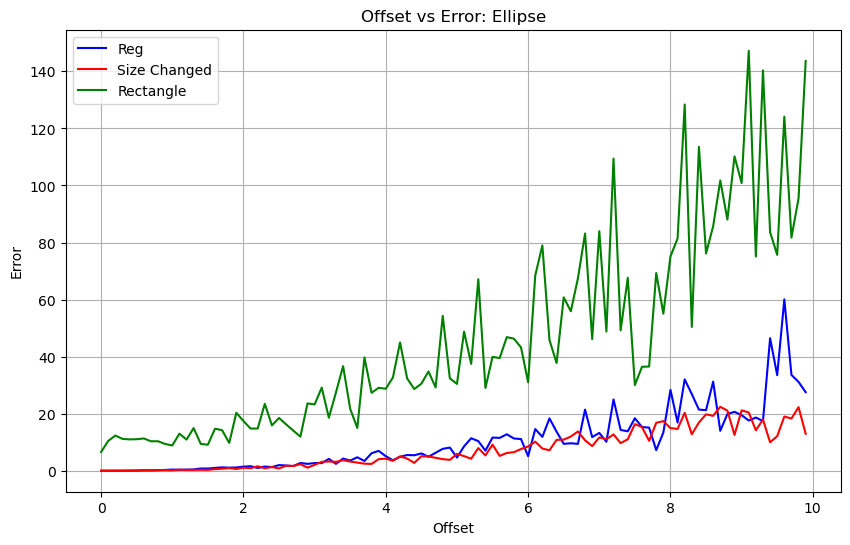

In [516]:
# CALC - Generate many random ellipses and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

# Base case
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    center, axes, angle = fit_ellipse(points)
    error = ellipse_error(points, center, axes, angle)
    if not math.isnan(error):
        y1[i] = error
    else:
        y1[i] = y1[i - 1]

y2 = np.zeros_like(x)

# Change ellipse shape
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 30, b = 30, center = [50, 50], offset = val, angle = 0)
    center, axes, angle = fit_ellipse(points)
    error = ellipse_error(points, center, axes, angle)
    if not math.isnan(error):
        y2[i] = error
    else:
        y2[i] = y2[i - 1] # smooth graph if error

y3 = np.zeros_like(x)

# Rect instead of ellipse
for i, val in enumerate(x):
    points = rect_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val)
    center, axes, angle = fit_ellipse(points)
    error = ellipse_error(points, center, axes, angle)
    if not math.isnan(error):
        y3[i] = error
    else:
        y3[i] = y3[i - 1] # smooth graph if error

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Size Changed')
plt.plot(x, y3, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Ellipse')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# NOTES: Changing the center, the angle has no effect on offset vs error
# If we double the offset, the error scales by 4 on avg
# If we double a or b, the error decreases by 2 on avg
# So if we double the size and the offset, error is the same - GOOD
# Even if a * b is constant, error is minimmized when a = b; long and skinny have higher error
# Even perfect rectangles have fairly high error - GOOD

Center: (np.float64(50.258023268533584), np.float64(50.060164873269855))
Axes lengths: (np.float64(80.04287376283071), np.float64(39.87899476685033))
Rotation angle: -32.509074927226884 degrees
Error: 0.5099824377079268


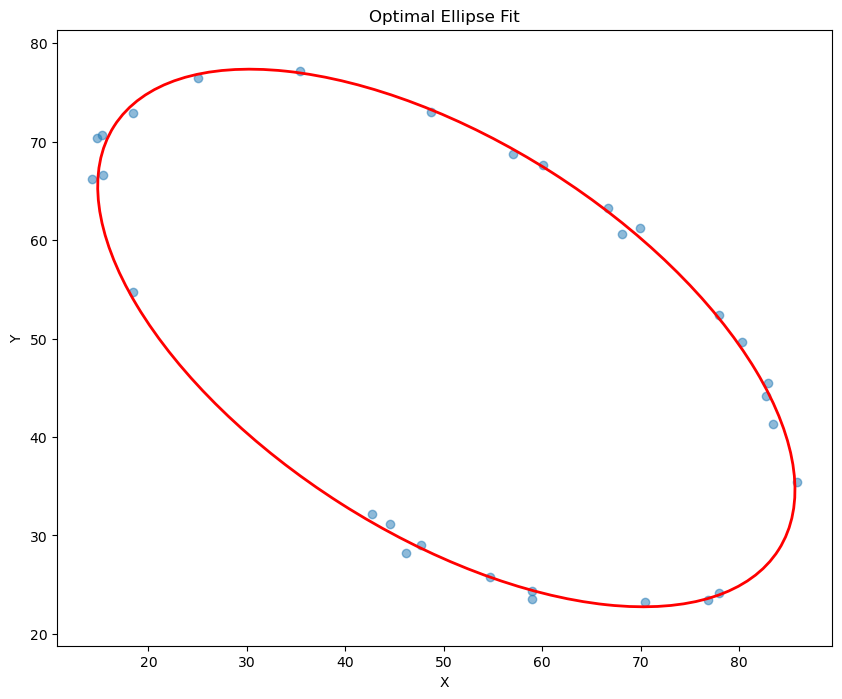

In [663]:
# CALC - Demo of optimal ellipse
test_pts = ell_pts(30, 20, 40, [50, 50], 1, 1)
center, axes, angle = fit_ellipse(test_pts)
err = ellipse_error(test_pts, center, axes, angle)
ellipse_results(test_pts, center, axes, angle, err)

# Optimal Rectangle

Finds a close to optimal rectangle and gives the error associated with it.

In [518]:
from scipy.optimize import minimize_scalar

def compute_centroid(points):
    return np.mean(points, axis=0)

def compute_major_axis_angle(points):
    centered = points - compute_centroid(points)
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    return np.arctan2(eigvecs[1, np.argmax(eigvals)], eigvecs[0, np.argmax(eigvals)])

def rotate_points(points, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(points - compute_centroid(points), rotation_matrix.T)

def compute_rectangle(rotated_points):
    min_x, min_y = np.percentile(rotated_points, 10, axis=0)
    max_x, max_y = np.percentile(rotated_points, 90, axis=0)
    return np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]])

def rotate_rectangle(rectangle, angle, centroid):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(rectangle, rotation_matrix.T) + centroid

def mean_squared_distance(points, rectangle):
    def point_to_rectangle_distance(point):
        x, y = point
        x1, y1 = rectangle[0]
        x2, y2 = rectangle[2]
        
        # Calculate distances to all edges
        left_dist = abs(x - x1)
        right_dist = abs(x - x2)
        top_dist = abs(y - y1)
        bottom_dist = abs(y - y2)
        
        min_dist = min(left_dist, right_dist, top_dist, bottom_dist)
        
        return min_dist**2
    
    distances = np.array([point_to_rectangle_distance(p) for p in points])
    return np.mean(distances)

def objective_function(angle, points):
    rotated = rotate_points(points, angle)
    rectangle = compute_rectangle(rotated)
    return mean_squared_distance(rotated, rectangle)

def fit_rectangle(points):
    centroid = compute_centroid(points)
    initial_angle = compute_major_axis_angle(points)
    
    result = minimize_scalar(
        lambda angle: objective_function(angle, points),
        method='brent',
        bracket=(initial_angle - np.pi/4, initial_angle + np.pi/4)
    )
    
    best_angle = result.x
    rotated_points = rotate_points(points, best_angle)
    best_rectangle = compute_rectangle(rotated_points)
    final_msd = objective_function(best_angle, points)
    
    return rotate_rectangle(best_rectangle, -best_angle, centroid), final_msd

# Error function (adjustable)
def rect_error(rectangle, msd):
    def rect_area(vertices):
        if vertices.shape[0] != 4:
            raise ValueError("There must be exactly four vertices.")
        
        # Extract the vertices
        x = vertices[:, 0]
        y = vertices[:, 1]
        
        # Calculate the side lengths using the distance formula
        side1 = ((x[1] - x[0])**2 + (y[1] - y[0])**2)**0.5
        side2 = ((x[2] - x[1])**2 + (y[2] - y[1])**2)**0.5
        
        # The area of the rectangle is the product of the two side lengths
        area = side1 * side2
        
        return area
    area = rect_area(rectangle)
    error = msd / (area)
    return error * 1000

# Print the results
def rect_results(rectangle, error, points):
    print("Best-fitted rectangle vertices:")
    print(rectangle)
    print("Error:")
    print(error)

    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
    plt.plot(np.append(rectangle[:, 0], rectangle[0, 0]),
                np.append(rectangle[:, 1], rectangle[0, 1]), 'r-')
    plt.axis('equal')
    plt.title('Best-fitted Rectangle')
    plt.show()

Best-fitted rectangle vertices:
[[71.1528907  57.43094422]
 [31.50006229 62.67947448]
 [29.60907742 48.39301817]
 [69.26190584 43.1444879 ]]
Error:
1.988782725592051


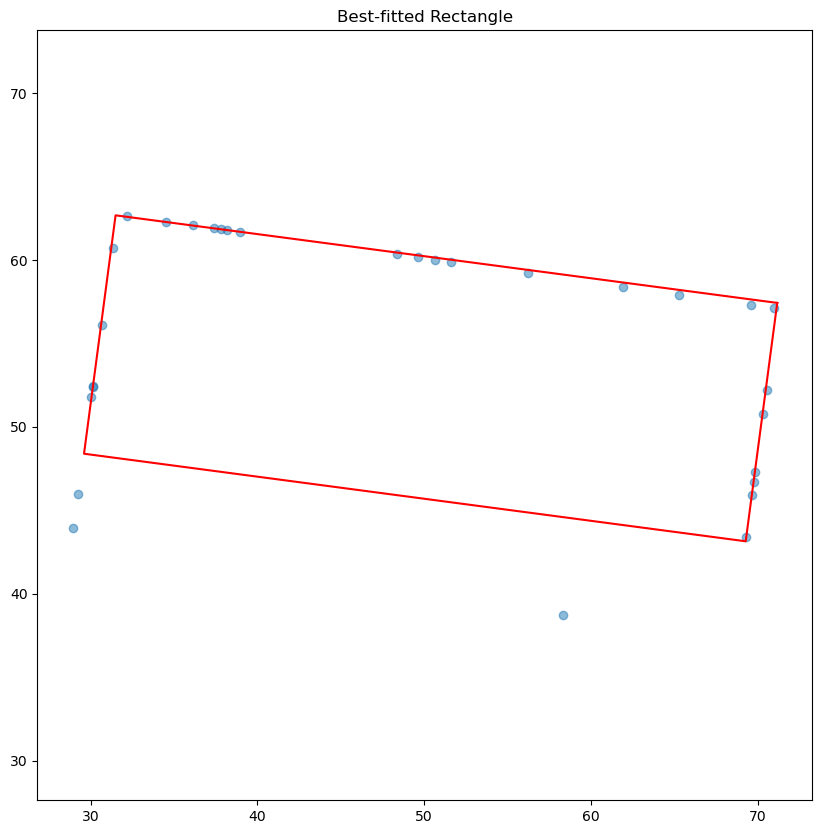

In [519]:
# CALC - Demo of optimal rectangle
points =  rect_pts(30, 40, 20, [50, 50], 0, 3)
rectangle, msd = fit_rectangle(points)
error = rect_error(rectangle, msd)
rect_results(rectangle, error, points)

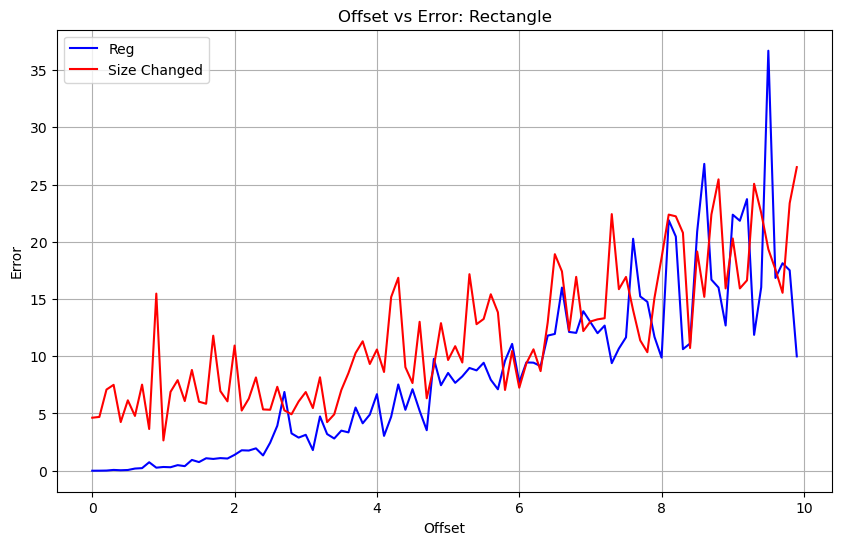

In [ ]:
# CALC - Generate many random rectangles and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

# Base case
for i, val in enumerate(x):
    points = rect_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    rectangle, error = fit_rectangle(points)
    y1[i] = error

y2 = np.zeros_like(x)

# Ellipse
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    rectangle, error = fit_rectangle(points)
    y2[i] = error

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Size Changed')
# plt.plot(x, y3, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Rectangle')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# NOTES: Changing the center has no effect on error
# Changing the angle has no effect on error
# If we double the offset, the error scales by ~3 on avg
# If we double a and b, the error slightly increases; it should, however, decrease - BAD
# Error minimized when a = b; but also decreases when extremely long and skinny - may be BAD
# Even perfect ellipses have much higher error for small offset values - GOOD

# Optimal Star
Finds the optimal 4-point star for a given collection of points and calculates the error

In [520]:
from scipy.optimize import minimize_scalar

def compute_centroid(points):
    return np.mean(points, axis=0)

def compute_major_axis_angle(points):
    centered = points - compute_centroid(points)
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    return np.arctan2(eigvecs[1, np.argmax(eigvals)], eigvecs[0, np.argmax(eigvals)])

def rotate_points(points, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(points - compute_centroid(points), rotation_matrix.T)

def compute_star(rotated_points):
    x0, y0 = np.percentile(rotated_points, 0, axis=0)
    x100, y100 = np.percentile(rotated_points, 100, axis=0)
    x50, y50 = (x0 + x100) / 2, (y0 + y100) / 2 #np.percentile(rotated_points, 50, axis=0)
    x25, y25 = (x0 + 3 * x50) / 4, (y0 + 3 * y50) / 4 #np.percentile(rotated_points, 25, axis=0)
    x75, y75 = (x100 + 3 * x50) / 4, (y100 +3 * y50) / 4 #np.percentile(rotated_points, 75, axis=0)
    # Compute star - 8 points
    return np.array([[x50, y100], 
                     [x75, y75], 
                     [x100, y50], 
                     [x75, y25],
                     [x50, y0],
                     [x25, y25],
                     [x0, y50],
                     [x25, y75]])

def rotate_star(star, angle, centroid):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(star, rotation_matrix.T) + centroid

def mean_squared_distance_star(points, star):
    def point_to_star_distance(star_vertices, point):
        def distance_to_line_segment(p, a, b):
            ab = b - a
            ap = p - a
            t = np.clip(np.dot(ap, ab) / np.dot(ab, ab), 0, 1)
            closest = a + t * ab
            return np.linalg.norm(p - closest)
    
        star_vertices = np.array(star_vertices)
        point = np.array(point)
        
        # Calculate the center of the star
        center = np.mean(star_vertices, axis=0)
        
        # Translate point relative to center
        relative_point = point - center
        
        # Determine which quadrant the point is in
        if relative_point[0] >= 0 and relative_point[1] >= 0:
            # First quadrant: check segments 0-1 and 1-2
            segments_to_check = [(0, 1), (1, 2)]
        elif relative_point[0] < 0 and relative_point[1] >= 0:
            # Second quadrant: check segments 6-7 and 7-0
            segments_to_check = [(6, 7), (7, 0)]
        elif relative_point[0] < 0 and relative_point[1] < 0:
            # Third quadrant: check segments 4-5 and 5-6
            segments_to_check = [(4, 5), (5, 6)]
        else:  # relative_point[0] >= 0 and relative_point[1] < 0
            # Fourth quadrant: check segments 2-3 and 3-4
            segments_to_check = [(2, 3), (3, 4)]
        
        # Initialize minimum distance to a large value
        min_distance = float('inf')
        
        # Check distance only to the relevant segments
        for start_idx, end_idx in segments_to_check:
            start = star_vertices[start_idx]
            end = star_vertices[end_idx]
            
            distance = distance_to_line_segment(point, start, end)
            min_distance = min(min_distance, distance)
        
        return min_distance ** 2
    
    distances = np.array([point_to_star_distance(star, p) for p in points])
    # print(np.mean(distances))
    return np.mean(distances)

def objective_function_star(angle, points):
    rotated = rotate_points(points, angle)
    star = compute_star(rotated)
    return mean_squared_distance_star(rotated, star)

def fit_star(points):
    centroid = compute_centroid(points)
    initial_angle = compute_major_axis_angle(points)
    
    result = minimize_scalar(
        lambda angle: objective_function_star(angle, points),
        method='brent',
        bracket=(initial_angle - np.pi/4, initial_angle + np.pi/4)
    )
    
    best_angle = result.x
    rotated_points = rotate_points(points, best_angle)
    best_star = compute_star(rotated_points)
    final_msd = objective_function_star(best_angle, points)
    
    return rotate_star(best_star, -best_angle, centroid), final_msd

def star_error(star, msd):
    def star_area(vertices):
        # Ensure the input is an 8x2 array
        if vertices.shape != (8, 2):
            raise ValueError("Input must be an 8x2 array")
        
        # Roll the array to easily access next vertex
        rolled = np.roll(vertices, -1, axis=0)
        
        # Apply the shoelace formula
        area = 0.5 * np.abs(np.sum(vertices[:, 0] * rolled[:, 1] - 
                                vertices[:, 1] * rolled[:, 0]))
        return area
    return msd / star_area(star) * 1000

# Print the results - 8 pt star
def star_results(star, error, points):
    print("Best-fitted star vertices:")
    print(star)
    print("Error:")
    print(error)


    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(points[:, 0], points[:, 1], alpha=0.5)
    
    # Plot the points
    ax.plot(star[:, 0], star[:, 1], 'r-')
    
    # Close the shape by connecting the last point to the first
    ax.plot([star[-1, 0], star[0, 0]], [star[-1, 1], star[0, 1]], 'r-')

    ax.axis('equal')
    ax.set_title('Best-fitted Star')
    plt.show()

Best-fitted star vertices:
[[16.35845058 70.96854059]
 [45.93762463 63.0394702 ]
 [69.4182205  81.45701568]
 [62.2518562  52.48828104]
 [81.61537687 28.76378395]
 [52.03620282 36.69285434]
 [28.55560695 18.27530886]
 [35.72197124 47.2440435 ]]
Error:
0.4839103929358808


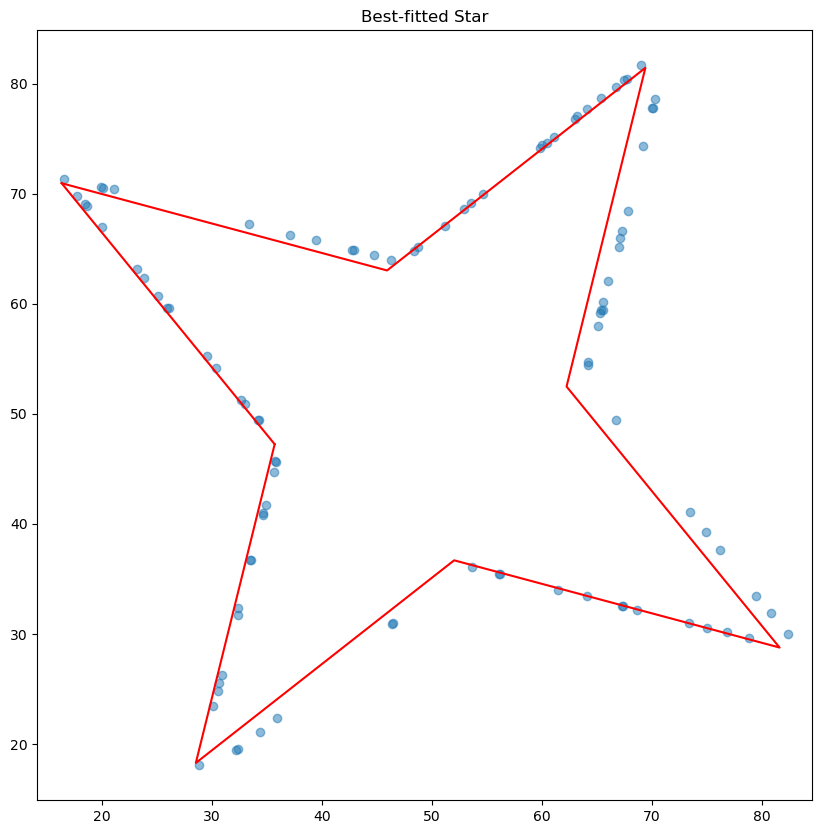

In [ ]:
# CALC - Demo of optimal star
points = star_pts(100, 40, [50, 50], 0.1, 1)
star, msd = fit_star(points)
error = star_error(star, msd)
star_results(star, error, points)

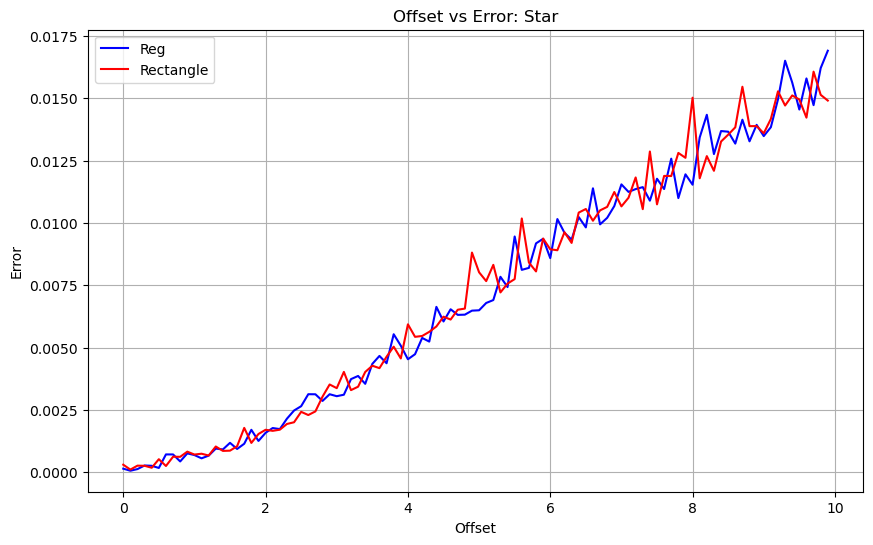

In [ ]:
# CALC - Generate many random stars and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

def run_star_tests(num_tests, num_pt, r, center, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = star_pts(num_pt=num_pt, r=r, center=center, offset=offset, angle=angle)
        star, msd = fit_star(points)
        error = star_error(star, msd)
        if not math.isnan(error):
            valid_errors.append(error)
    return valid_errors

def run_rect_tests(num_tests, num_pt, a, b, center, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = rect_pts(num_pt=num_pt, a = a, b = b, center=center, offset=offset, angle=angle)
        star, msd = fit_star(points)
        error = star_error(star, msd)
        if not math.isnan(error):
            valid_errors.append(error)
    return valid_errors


# Base case
for i, val in enumerate(x):
    errors = run_star_tests(num_tests = 3, num_pt = 200, r = 30, center = [50, 50], offset = val, angle = 0)
    if errors:
        y1[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y1[i] = y1[i - 1] if i > 0 else np.nan

y2 = np.zeros_like(x)

# Rectangle
for i, val in enumerate(x):
    errors = run_star_tests(num_tests = 3, num_pt = 200, r = 300, center = [50, 50], offset = 10 * val, angle = 0)
    # run_rect_tests(num_tests = 3, num_pt = 30, a = 30, b= 30, center = [50, 50], offset = val, angle = 0)
    if errors:
        y2[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y2[i] = y2[i - 1] if i > 0 else np.nan

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Rectangle')
# plt.plot(x, y2 / y1, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Star')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# NOTES: Error scales with offset, but a lot of noise/inconsistency - BAD
# Changing center, angle does not affect error
# If we double the offset, the error scales by 4 on avg, but it scales more for higher offset - not linear; got up to 10 at higher
# If we double the size and keep the same offset, the error increases by 2.5 x on avg - BAD, should decrease
# But there is a lot of variance, from 1x to 6x
# So if we double the offset and the size, the error scales by 4 - 24x; BAD, should stay the same
# Even perfect rectangles/other shapes have high error - GOOD

# Optimal Triangle

In [542]:
from scipy.optimize import minimize_scalar

def compute_triangle(rotated_points):
    x0, y0 = np.percentile(rotated_points, 0, axis=0)
    x100, y100 = np.percentile(rotated_points, 100, axis=0)
    x50, y50 = (x0 + x100) / 2, (y0 + y100) / 2 #np.percentile(rotated_points, 50, axis=0)
    # Compute triangle
    return np.array([[x0, y0], 
                     [x100, y0], 
                     [x50, y100]])

def mean_squared_distance_triangle(points, triangle):
    def point_to_triangle_distance(tri_vertices, point):
        def distance_to_line_segment(p, a, b):
            ab = b - a
            ap = p - a
            t = np.clip(np.dot(ap, ab) / np.dot(ab, ab), 0, 1)
            closest = a + t * ab
            return np.linalg.norm(p - closest)
        
        # Initialize minimum distance to a large value
        min_distance = float('inf')
        
        # Check distance only to the relevant segments
        for i in range(3):
            start = tri_vertices[i]
            end = tri_vertices[(i + 1) % 3]
            distance = distance_to_line_segment(point, start, end)
            min_distance = min(min_distance, distance)
        
        return min_distance ** 2
    
    distances = np.array([point_to_triangle_distance(triangle, p) for p in points])
    # print(np.mean(distances))
    return np.mean(distances)

def objective_function_triangle(angle, points):
    rotated = rotate_points(points, angle)
    triangle = compute_triangle(rotated)
    return mean_squared_distance_triangle(rotated, triangle)

def fit_triangle(points):
    centroid = compute_centroid(points)
    initial_angle = compute_major_axis_angle(points)
    
    # Center the points
    centered_points = points - centroid
    
    # Define the three starting angles, 120 degrees apart
    starting_angles = [initial_angle, initial_angle + 2*np.pi/3, initial_angle + 4*np.pi/3]
    
    best_triangle = None
    best_msd = float('inf')
    best_angle = None
    
    for start_angle in starting_angles:
        result = minimize_scalar(
            lambda angle: objective_function_triangle(angle, centered_points),
            method='brent',
            bracket=(start_angle - np.pi/4, start_angle + np.pi/4)
        )
        
        current_angle = result.x
        rotated_points = rotate_points(centered_points, current_angle)
        current_triangle = compute_triangle(rotated_points)
        current_msd = objective_function_triangle(current_angle, centered_points)
        
        if current_msd < best_msd:
            best_msd = current_msd
            best_triangle = current_triangle
            best_angle = current_angle
    
    # Rotate the best triangle back to the original orientation
    final_triangle = rotate_triangle(best_triangle, -best_angle, np.zeros(2))
    
    # Translate the triangle back to the original position
    final_triangle += centroid
    
    return final_triangle, best_msd

# Can also be used to rotated points around a center; rotation function used for triangles, among other things
def rotate_triangle(triangle, angle, center):
    c, s = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[c, -s], [s, c]])
    rotated_triangle = np.dot(triangle - center, rotation_matrix.T) + center
    return rotated_triangle

def tri_area(triangle):
    # Extract the vertices
    A, B, C = triangle
    
    # Calculate two edges of the triangle
    AB = B - A
    AC = C - A
    
    cross_product_magnitude = abs(AB[0] * AC[1] - AB[1] * AC[0])

    # The area is half of the magnitude of the cross product
    area = 0.5 * cross_product_magnitude

    return area

def tri_error(triangle, msd):
    if triangle is not None and msd is not None:
        ta = tri_area(triangle)
        if ta > 1e-10:
            return msd / tri_area(triangle) * 1000
    return None

# Print the results
def tri_results(triangle, error, points):
    if triangle is not None:
        print("Best-fitted triangle vertices:")
        print(triangle)
        print("Error:")
        print(error)

        fig, ax = plt.subplots(figsize=(10, 10))

        ax.scatter(points[:, 0], points[:, 1], alpha=0.5)
        
        # Plot the points
        ax.plot(triangle[:, 0], triangle[:, 1], 'r-')
        
        # Close the shape by connecting the last point to the first
        ax.plot([triangle[-1, 0], triangle[0, 0]], [triangle[-1, 1], triangle[0, 1]], 'r-')

        ax.axis('equal')
        ax.set_title('Best-fitted Triangle')
        plt.show()

In [687]:
def fit_triangle2(points):
    if points.shape[0] < 3:
        return None  # Not enough points to form a triangle

    # Find extreme points
    bottom_idx = np.argmin(points[:, 1])
    right_idx = np.argmax(points[:, 0])
    top_idx = np.argmax(points[:, 1])
    left_idx = np.argmin(points[:, 0])

    # Get unique extreme points while preserving order
    extreme_indices = [bottom_idx, right_idx, top_idx, left_idx]
    unique_indices = []
    for idx in extreme_indices:
        if idx not in unique_indices:
            unique_indices.append(idx)

    unique_points = points[unique_indices]

    if len(unique_points) == 2:
        return None  # Only two unique extreme points, can't form a triangle
    elif len(unique_points) == 3:
        return unique_points
    elif len(unique_points) == 4:
        bottom, right, top, left = unique_points

        # Find closest pair of adjacent points
        distances = [
            np.sum((bottom - left)**2),
            np.sum((bottom - right)**2),
            np.sum((top - left)**2),
            np.sum((top - right)**2)
        ]

        closest = np.argmin(distances)
        if closest == 0:  # bottom left
            p1, p2, p3, p4 = right, bottom, left, top
        elif closest == 1:  # bottom right
            p1, p2, p3, p4 = left, bottom, right, top
        elif closest == 2:  # top left
            p1, p2, p3, p4 = right, top, left, bottom
        else:  # top right
            p1, p2, p3, p4 = bottom, right, top, left

        tolerance = 1e-10
        # Direction vectors
        v1 = p2 - p1
        v2 = p4 - p3
        
        # Check if lines are parallel
        cross_product = v1[0] * v2[1] - v1[1] * v2[0]
        if abs(cross_product) < tolerance:
            # Lines are parallel, return None instead of raising an error
            return None
        
        # Solve the linear system
        A = np.column_stack((v1, -v2))
        b = p3 - p1
        
        try:
            t, _ = np.linalg.solve(A, b)
            intersection = p1 + t * v1
            return np.array([p1, intersection, p4])
        except np.linalg.LinAlgError:
            return None

    return None  # This should never happen, but just in case

def fit_triangle_updated(points, num_angles = 12):
    # Rotate points to many different angles
    tris = []
    for i in range(num_angles):
        angle = 2 * np.pi * i / num_angles
        rot_pts = rotate_triangle(points, angle, [0, 0])
        t = fit_triangle2(rot_pts)
        if t is not None:
            tris.append(rotate_triangle(t, -angle, [0, 0]))
    
    if len(tris) < 1:
        return None, None
    
    tris = np.array(tris).reshape(-1, 2)
    # Now, we construct a new array of points from all the triangles and do fit_triangle2 on it
    best_tri = fit_triangle2(tris)
    reg_tri = fit_triangle2(points)

    if best_tri is not None and reg_tri is None:
        msd = mean_squared_distance_triangle(points, best_tri)
        return best_tri, msd
    if reg_tri is not None and best_tri is None:
        msd = mean_squared_distance_triangle(points, reg_tri)
        return reg_tri, msd
    elif reg_tri is not None and best_tri is not None:
        if mean_squared_distance_triangle(points, reg_tri) < mean_squared_distance_triangle(points, best_tri):
            return reg_tri, mean_squared_distance_triangle(points, reg_tri)
        else:
            return best_tri, mean_squared_distance_triangle(points, best_tri)
    else:
        return None, None

0
1
2
3
4
5
6
7
8
9
10
11
Best-fitted triangle vertices:
[[  1.52569714  -6.3940389 ]
 [125.39354687 -15.20083036]
 [ 99.5963315  107.25723566]]
Error:
0.030733505056117452


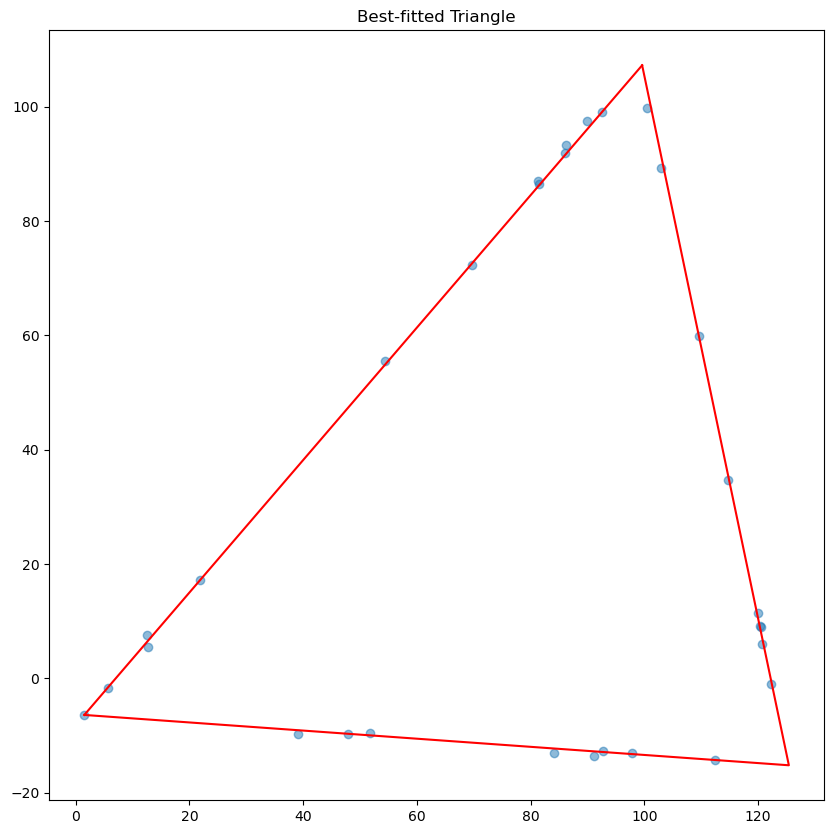

In [688]:
# CALC - Demo of optimal triangle
points = tri_pts(30, 150, 100, [50, 50], 1, 4)
# points = np.array([[0, 0], [50, 50]])
tri, msd = fit_triangle_updated(points)
error = tri_error(tri, msd)
tri_results(tri, error, points)

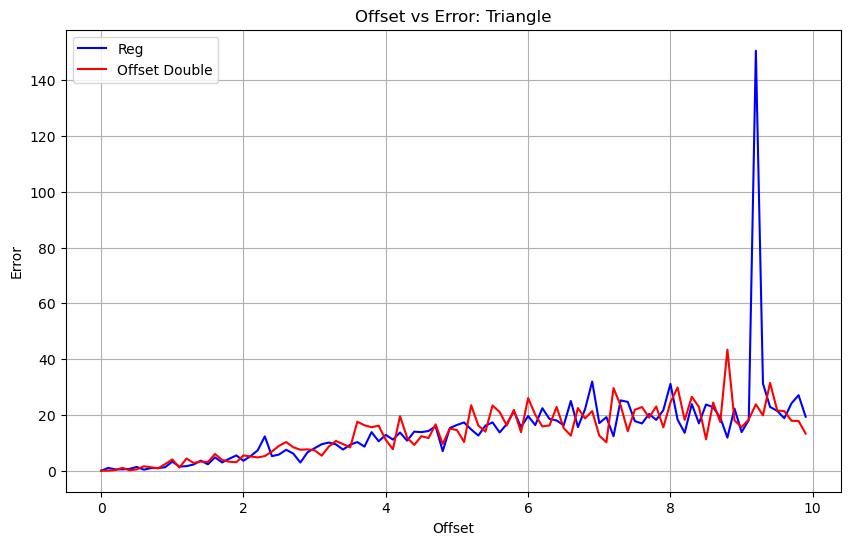

In [523]:
# CALC - Generate many random triangles and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

def run_tri_tests(num_tests, num_pt, a, b, base, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = tri_pts(num_pt, a, b, base, offset, angle)
        tri, msd = fit_triangle_updated(points)
        error = tri_error(tri, msd)
        if error is not None:
            valid_errors.append(error)
        else:
            print("Error")
    return valid_errors

# Base case
for i, val in enumerate(x):
    errors = run_tri_tests(num_tests = 3, num_pt = 30, a = 20, b = 40, base = [50, 50], offset = val, angle = 0)
    if errors:
        y1[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y1[i] = y1[i - 1] if i > 0 else np.nan

y2 = np.zeros_like(x)

# Test
for i, val in enumerate(x):
    errors = run_tri_tests(num_tests = 3, num_pt = 30, a = 40, b = 80, base = [50, 50], offset = 2 * val, angle = 0)
    if errors:
        y2[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y2[i] = y2[i - 1] if i > 0 else np.nan

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Offset Double')
# plt.plot(x, y2 / y1, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Triangle')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# top point, left and right - simple approximations

# NOTES: Error scales with offset, but a lot of noise/inconsistency - BAD
# Changing center, angle does not affect error
# If we double the offset, the error scales by 2.25 on avg
# If we double the size and keep the same offset, the error increases by 3.7x on avg, much noise - BAD, should decrease
# Even perfect rectangles/other shapes have high error - GOOD

# Error Standardization
To ensure that the same error threshold is used for all different shapes, we run some tests to see how error scales for different offsets for various shapes

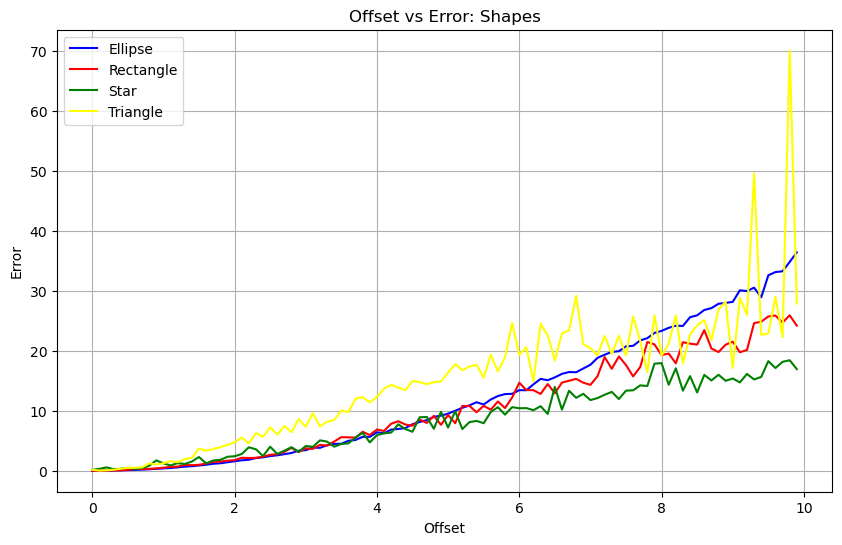

In [619]:
def run_star_tests(num_tests, num_pt, r, center, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = star_pts(num_pt=num_pt, r=r, center=center, offset=offset, angle=angle)
        star, msd = fit_star(points)
        error = star_error(star, msd)
        if not math.isnan(error):
            valid_errors.append(error)
    return valid_errors

def run_tri_tests(num_tests, num_pt, a, b, base, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = tri_pts(num_pt, a, b, base, offset, angle)
        tri, msd = fit_triangle_updated(points)
        error = tri_error(tri, msd)
        if error is not None:
            valid_errors.append(error)
    return valid_errors

def run_rect_tests(num_tests, num_pt, a, b, center, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = rect_pts(num_pt=num_pt, a = a, b = b, center=center, offset=offset, angle=angle)
        rect, msd = fit_rectangle(points)
        error = rect_error(rect, msd)
        if not math.isnan(error):
            valid_errors.append(error)
    return valid_errors

def run_ellipse_tests(num_tests, num_pt, a, b, center, offset, angle):
    valid_errors = []
    for _ in range(num_tests):
        points = ell_pts(num_pt, a, b, center, offset, angle)
        center, axes, angle = fit_ellipse(points)
        error = ellipse_error(points, center, axes, angle)
        if not math.isnan(error):
            valid_errors.append(error)
    return valid_errors

x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x) # ellipse
y2 = np.zeros_like(x) # rectangle
y3 = np.zeros_like(x) # star
y4 = np.zeros_like(x) # triangle

for i, val in enumerate(x):
    errors = run_ellipse_tests(num_tests = 3, num_pt = 100, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    if errors:
        y1[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y1[i] = y1[i - 1] if i > 0 else np.nan

for i, val in enumerate(x):
    errors = run_rect_tests(num_tests = 3, num_pt = 100, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    if errors:
        y2[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y2[i] = y2[i - 1] if i > 0 else np.nan

for i, val in enumerate(x):
    errors = run_star_tests(num_tests = 3, num_pt = 100, r = 30, center = [50, 50], offset = val, angle = 0)
    if errors:
        y3[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y3[i] = y3[i - 1] if i > 0 else np.nan

for i, val in enumerate(x):
    errors = run_tri_tests(num_tests = 3, num_pt = 100, a = 20, b = 40, base = [50, 50], offset = val, angle = 0)
    if errors:
        y4[i] = np.mean(errors)
    else:
        print(f"All tests resulted in errors for x={val}")
        y4[i] = y4[i - 1] if i > 0 else np.nan


# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Ellipse')
plt.plot(x, y2, color='red', label='Rectangle')
plt.plot(x, y3, color='green', label='Star')
plt.plot(x, y4, color='yellow', label='Triangle')

# Customize the plot
plt.title('Offset vs Error: Shapes')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Data Sets from Image
In order to get data to run shape tests on, it would be ideal to get data directly from the image in addition to the segmentation, so that a bad segmentation won't throw everything off. However, to start, we will simply look at the segmentation regions' boundaries, as these are easier to convert into relevant data sets -- in the future, we will branch out to more accurate techniques

In [690]:
# New cleaner functions for testing each - return error immediately
def rectangulate(points):
    rectangle, msd = fit_rectangle(points)
    error = rect_error(rectangle, msd)
    return rectangle, error

def ellipsulate(points):
    center, axes, angle = fit_ellipse(points)
    ell_err = ellipse_error(points, center, axes, angle)
    return center, axes, angle, ell_err

def starulate(points):
    star, msd = fit_star(points)
    error = star_error(star, msd)
    return star, error

def triangulate(points, buffer = 10, num_ang = 24):
    tri, msd = fit_triangle_updated(points, num_ang)
    error = tri_error(tri, msd)
    # Check triangle to see if it is OK or messed up
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    if tri is not None:
        for vertex in tri:
            if not (min_x - buffer <= vertex[0] <= max_x + buffer and min_y - buffer <= vertex[1] <= max_y + buffer):
                return None, None
    return tri, error

In [657]:
# Run trace; gets path variables and such
%run trace.ipynb

In [691]:
# List of points fromd decomposed path
def pts_from_decpath(decpath):
    points = []
    if len(decpath) == 0:
        path = decpath[0]
        for point in path.pt:
            points.append([point.x, point.y])
    else:
        for path in (decpath):
            for point in path.pt[:-1]:
                points.append([point.x, point.y])

    # Get numpy array of points
    return np.array(points)

# Show collection of points
def show_region_pts(pts, buffer = 30):
    plt.scatter(pts[:, 0], pts[:, 1], c='blue', marker='o')
    plt.grid(True)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(np.min(pts[:, 0]) - buffer, np.max(pts[:, 0]) + buffer)
    plt.ylim(np.min(pts[:, 1]) - buffer, np.max(pts[:, 1]) + buffer)
    # Set labels for clarity
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()

thresh = 1
# Show some path point collections
for i in range(len(plist)):
    points = pts_from_decpath(plist[i])
    # rect, rect_err = rectangulate(points) # 3 sec
    # center, axes, angle, ell_err = ellipsulate(points) # 0.2 sec
    # star, star_err = starulate(points) # 20 sec - SLOW
    triangle, tri_err = triangulate(points) # 2.4 sec

    # if rect_err is not None: # FIX ERROR
    #     if rect_err < thresh:
    #         print(i)
    #         show_region_pts(points, i)
    #         rect_results(rect, rect_err, points)

    # if ell_err is not None:
    #     if ell_err < thresh:
    #         print(i)
    #         show_region_pts(points, i)
    #         ellipse_results(points, center, axes, angle, ell_err)

    # if star_err is not None:
    #     if star_err < thresh: # ISSUE: star almost never fits -- probably should not use, rare shape anyway
    #         print(i)
    #         show_region_pts(points, i)
    #         star_results(star, star_err, points)
    
    # if tri_err is not None:
    #     if tri_err < thresh:
    #         print(i)
    #         show_region_pts(points, i)
    #         tri_results(triangle, tri_err, points)


# TO DO: SLOW right now, need to speed up - can consider fewer points (just polygon points), use metric to throw most out
# Triangle is broken right now - need to ensure that it is within a certain bounding box of the points plus small buffer, else discard (easy)
# Ellipse error is insanely high, should be fixed - also, we encounter bad values in sqrts, add error handling

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3


In [ ]:
rect, rect_err = rectangulate(points)
center, axes, angle, ell_err = ellipsulate(points)
star, star_err = starulate(points)
triangle, tri_err = triangulate(points)

rect_results(rect, rect_err, points) # Rect error can be low even for clear non-rectangles (curves) - too low
ellipse_results(points, center, axes, angle, ell_err)
star_results(star, star_err, points)
tri_results(triangle, tri_err, points) # Long skinny triangles can break things - FIX, don't allow this

TO DO TUES:
- Clean up code - eliminate unnecessary stuff in triangle - format all better
- Implement area-based penalty to eliminate small regions before they are checked - can do with num pts; area not tracked; and also discard long and skinny - minimum for each dimension, and also ratio needed
- Think of ways to get better point sets from image
- Create calculation pipeline to test for a given shape - order of tests, when to break (if threshold good enough), metrics to see if we should even waste time on a test or not - try with many example shapes from rasterized vector images, get working well

REMAINING PROBLEMS:
- Star and triangle fitting is inconsistent; doesn't need to be perfect, may not use
- For slow tests, can use a metric to determine if we even test it; decision tree with fast stats
- Speed - how fast to do many tests? How to cut down number of tests by eliminating bad candidates quickly?
- How to make sure this is handled correctly in the tracing step? We can flag each region with its shape and parameters going into the tracing step, then when tracing the path, treat it differently if it was flagged by making sure component paths all lie on the ideal shape -- if multiple neighbor each other, take the average, perhaps? Unlikely scenario though, should manually create it to test behavior
- Workflow: 
    - Find a way to get good test sets from image
    - Use these to standardize error metrics to same scale and create test pipeline
    - Develop time-saving metrics (can do later)
    - Implement this as phase between segmentation and tracing, where each region is processed and marked as a perfect shape or not (there will be a parameter of sensitivity that controls how much variance there can be from perfect)
    - Update tracing to take this into account - perfect shapes get special treatment, neighboring perfect shapes as well -
    - At this point, we can test on Boris segmentation, and try to fix issues like jagged lines - but mostly this is the end of the project - clean up code, optimize, add comments for readability, make project presentable
